In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')

detector_params = cv2.SimpleBlobDetector_Params()
detector_params.filterByArea = True
detector_params.maxArea = 1500
# detector_params.filterByCircularity = False
detector = cv2.SimpleBlobDetector_create(detector_params)
eye_detector = cv2.SimpleBlobDetector_create(detector_params)

In [7]:
from utils import detect_face_coords, detect_eyes_coords, remove_eyebrows, find_best_threshold, is_contour_circular

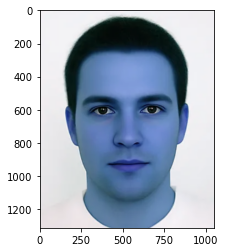

In [17]:
filename = '7.png'
img_blob = cv2.imread('images/' + filename)
img_contour = cv2.imread('images/' + filename)

plt.imshow(img_blob)

# Blob Detection Model

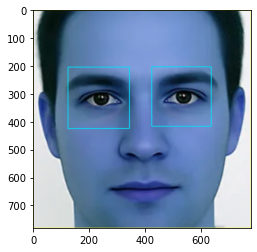

In [18]:
face_coords = detect_face_coords(img_blob, face_cascade)
fx, fy, fw, fh = face_coords
cv2.rectangle(img_blob, (fx, fy), (fx + fw, fy + fh), (255, 255, 0), 2)

face_frame = img_blob[fy : fy + fh, fx : fx + fw]

left_eye_coords, right_eye_coords = detect_eyes_coords(face_frame, eye_cascade)
lx, ly, lw, lh = left_eye_coords
rx, ry, rw, rh = right_eye_coords
cv2.rectangle(face_frame, (lx, ly), (lx + lw, ly + lh), (0, 225, 255), 2)
cv2.rectangle(face_frame, (rx, ry), (rx + rw, ry + rh), (0, 225, 255), 2)

left_eye_frame = face_frame[ly : ly + lh, lx : lx + lw]
right_eye_frame = face_frame[ry : ry + rh, rx : rx + rw]
eye_frames = [left_eye_frame, right_eye_frame]
plt.imshow(face_frame)

No keypoints found!


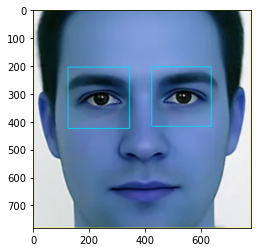

In [19]:
for eye in eye_frames:
        eye = remove_eyebrows(eye)
        gray_frame = cv2.cvtColor(eye, cv2.COLOR_BGR2GRAY)

        _, eye_img = cv2.threshold(gray_frame, 42, 255, cv2.THRESH_BINARY)
        keypoints = eye_detector.detect(eye_img)
        if len(keypoints) == 0:
            print('No keypoints found!')
        cv2.drawKeypoints(eye, keypoints, eye, (0, 0, 255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(face_frame)

In [ ]:
plt.imsave("outputs/blob/output_" + filename, face_frame)

# Contour Detection Model

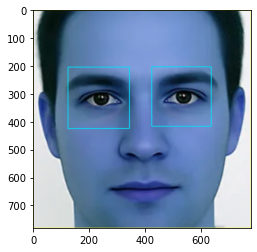

In [14]:
face_coords = detect_face_coords(img_contour, face_cascade)
fx, fy, fw, fh = face_coords
cv2.rectangle(img_contour, (fx, fy), (fx + fw, fy + fh), (255, 255, 0), 2)

face_frame = img_contour[fy : fy + fh, fx : fx + fw]

left_eye_coords, right_eye_coords = detect_eyes_coords(face_frame, eye_cascade)
lx, ly, lw, lh = left_eye_coords
rx, ry, rw, rh = right_eye_coords
cv2.rectangle(face_frame, (lx, ly), (lx + lw, ly + lh), (0, 225, 255), 2)
cv2.rectangle(face_frame, (rx, ry), (rx + rw, ry + rh), (0, 225, 255), 2)

left_eye_frame = face_frame[ly : ly + lh, lx : lx + lw]
right_eye_frame = face_frame[ry : ry + rh, rx : rx + rw]
eye_frames = [left_eye_frame, right_eye_frame]
plt.imshow(face_frame)

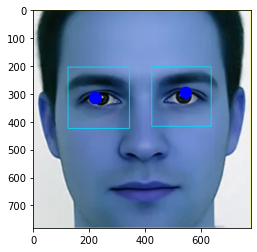

In [15]:
for eye in eye_frames:
        eye = remove_eyebrows(eye)
        gray_frame = cv2.cvtColor(eye, cv2.COLOR_BGR2GRAY)
        gray_frame = cv2.GaussianBlur(gray_frame, (9, 9), 0)

        threshold = find_best_threshold(gray_frame)
        _, eye_img = cv2.threshold(gray_frame, threshold, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(eye_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contours = contours[1:] # removes the window frame contour
        contours = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)

        if len(contours) > 0:
            largest_contour = contours[0]
            if is_contour_circular(largest_contour):
                cv2.drawContours(eye, contours, 0, (0,0,255), 3)
            else:
                largest_contour = contours[0]
                contour_coords = largest_contour.reshape(-1, 2)
                center_x = np.mean(contour_coords[:, 0])
                center_y = np.mean(contour_coords[:, 1])
                cv2.circle(eye, (int(center_x), int(center_y)), int(eye.shape[0]/7), (0, 0, 255), -1)
plt.imshow(face_frame)

In [ ]:
plt.imsave("outputs/contour/output_" + filename, face_frame)

In [ ]:
plt.imshow(eye_frames[0])

In [ ]:
plt.imshow(eye_frames[1])

# Live Video Detection

In [ ]:
cap = cv2.VideoCapture(0)
while True:
    _, frame = cap.read()
    face_coords = detect_face_coords(frame, face_cascade)
    fx, fy, fw, fh = face_coords
    if np.sum(face_coords) > 0:
        
        cv2.rectangle(frame, (fx, fy), (fx + fw, fy + fh), (255, 255, 0), 2)
        face_frame = frame[fy : fy + fh, fx : fx + fw]

        left_eye_coords, right_eye_coords = detect_eyes_coords(face_frame, eye_cascade)
        lx, ly, lw, lh = left_eye_coords
        rx, ry, rw, rh = right_eye_coords
        if np.sum(left_eye_coords) > 0 and np.sum(right_eye_coords) > 0:
            cv2.rectangle(face_frame, (lx, ly), (lx + lw, ly + lh), (0, 225, 255), 2)
            cv2.rectangle(face_frame, (rx, ry), (rx + rw, ry + rh), (0, 225, 255), 2)

            left_eye_frame = face_frame[ly : ly + lh, lx : lx + lw]
            right_eye_frame = face_frame[ry : ry + rh, rx : rx + rw]
            eye_frames = [left_eye_frame, right_eye_frame]

            for eye in eye_frames:
                eye = remove_eyebrows(eye)
                gray_frame = cv2.cvtColor(eye, cv2.COLOR_BGR2GRAY)
                gray_frame = cv2.GaussianBlur(gray_frame, (9, 9), 0)

                threshold = find_best_threshold(gray_frame)
                _, eye_img = cv2.threshold(gray_frame, threshold, 255, cv2.THRESH_BINARY)
                contours, _ = cv2.findContours(eye_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                contours = contours[1:] # removes the window frame contour
                contours = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)

                if contours:
                    cv2.drawContours(eye, contours, 0, (0,255,0), 3)
        
        cv2.imshow('Iris Detection', frame[fy : fy + fh, fx : fx + fw])
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()